<a href="https://colab.research.google.com/github/DonRoboto/Cursos/blob/master/Jorge_Calvillo_0bjectDetection_Yolov3Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# You Only Look Once!
La detección de objetos consiste en localizar múltiples elementos en una imagen. Este problema se ha abordado a través de diferentes algoritmos. En los primeros enfoques se proponían ventanas deslizantes que ejecutaban clasificadores sobre regiones de las imágenes. Cuando a una región se lograba asignar una clase, se decía que se había detectado un objeto. 
Posteriormente aparecieron los detectores que trabajaban a dos pasos. En el primero, un mecanismo que podía ser una red neuronal, proponia una región de la imagen donde era probable encontrar un objeto. En el segundo paso se corria un algoritmo clasificador, sobre la región propuesta, para determinar la etiqueta del objeto. 
Yolo fue de los primeros algoritmos que revolucionaron la detección al ejecutar la tarea en un solo paso. Desde el 2015, que apareció la primera versión, han salido variantes que buscan mejorar el proceso de detección, ya sea aumentando la velocidad o la precisión.
Te invitamos a descubrir la magia detrás de Yolo v3.

Bibliografía para este ejercicio:
- Ivan Vasilev, Daniel Slater, Et al. Python Deep Learning, 2019, segunda edición.
- You Only Look Once: Unified, Real-Time Object Detection (https://arxiv.org/abs/1506.02640) por Joseph Redmon, Santosh Divvala, Ross Girshick, y Ali Farhadi
- YOLO9000: Better, Faster, Stronger (https://arxiv.org/abs/1612.08242) por Joseph Redmon y Ali Farhadi
- YOLOv3: An Incremental Improvement (https://arxiv.org/abs/1804.02767) por Joseph Redmon y Ali Farhadi

In [0]:
import cv2                        # Librería para procesamiento de imágenes 
import numpy as np                # Librería para operaciones matemáticas
import matplotlib.pyplot as plt   # Librería para graficar
import requests                   # Librería para solicitudes Http  

## Configuración del modelo
Para reconstruir un modelo pre-entrenado, como Yolo v3, necesitamos los archivos de configuración y de pesos de la red. 


In [0]:
# Por medio de una petición "get" obtenemos el archivo de configuración que contiene
# las características de la arquitectura de Yolo v3.
yolo_config = 'yolov3.cfg'
url = 'https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg'
r = requests.get(url)
# La sentencia with provee de una forma "limpia" de abrir y cerrar un archivo.
with open(yolo_config, 'wb') as f: 
    f.write(r.content)

In [0]:
# Imprimimos las líneas del archivo de configuración.
with open(yolo_config, 'r') as f: 
    for line in f.readlines():
      print(line)

[net]

# Testing

# batch=1

# subdivisions=1

# Training

batch=64

subdivisions=16

width=608

height=608

channels=3

momentum=0.9

decay=0.0005

angle=0

saturation = 1.5

exposure = 1.5

hue=.1



learning_rate=0.001

burn_in=1000

max_batches = 500200

policy=steps

steps=400000,450000

scales=.1,.1



[convolutional]

batch_normalize=1

filters=32

size=3

stride=1

pad=1

activation=leaky



# Downsample



[convolutional]

batch_normalize=1

filters=64

size=3

stride=2

pad=1

activation=leaky



[convolutional]

batch_normalize=1

filters=32

size=1

stride=1

pad=1

activation=leaky



[convolutional]

batch_normalize=1

filters=64

size=3

stride=1

pad=1

activation=leaky



[shortcut]

from=-3

activation=linear



# Downsample



[convolutional]

batch_normalize=1

filters=128

size=3

stride=2

pad=1

activation=leaky



[convolutional]

batch_normalize=1

filters=64

size=1

stride=1

pad=1

activation=leaky



[convolutional]

batch_normalize=1

filters=128

size=3



In [0]:
# Por medio de una petición "get" obtenemos el archivo de pesos de la red Yolo v3.
yolo_weights = 'yolov3.weights'
url = 'https://pjreddie.com/media/files/yolov3.weights'
r = requests.get(url)
with open(yolo_weights, 'wb') as f:
    f.write(r.content)

In [0]:
# Por medio de una petición "get" obtenemos el archivo que contiene los nombres de 
# las clases que Yolo v3 puede reconocer.
# Nota: la versión v3 de Yolo fue entrenada con la base de datos Coco.  
# Coco contiene miles de imágenes distribuidas en 80 clases.
yolo_classes = 'coco.names'
url = 'https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names'
r = requests.get(url)
with open(yolo_classes, 'wb') as f:
    f.write(r.content)

In [0]:
# Revisamos los nombres de las clases.
with open(yolo_classes, 'r') as f:
    for line in f.readlines():
      print(line)

person

bicycle

car

motorbike

aeroplane

bus

train

truck

boat

traffic light

fire hydrant

stop sign

parking meter

bench

bird

cat

dog

horse

sheep

cow

elephant

bear

zebra

giraffe

backpack

umbrella

handbag

tie

suitcase

frisbee

skis

snowboard

sports ball

kite

baseball bat

baseball glove

skateboard

surfboard

tennis racket

bottle

wine glass

cup

fork

knife

spoon

bowl

banana

apple

sandwich

orange

broccoli

carrot

hot dog

pizza

donut

cake

chair

sofa

pottedplant

bed

diningtable

toilet

tvmonitor

laptop

mouse

remote

keyboard

cell phone

microwave

oven

toaster

sink

refrigerator

book

clock

vase

scissors

teddy bear

hair drier

toothbrush



In [0]:
# Creamos una lista con los nombres de las clases de la base Coco
with open(yolo_classes, 'r') as f:
    classes = [line.strip() for line in f.readlines()]


In [0]:
# Imprimimos la lista con las clases.
print(classes)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [0]:
# Imprimimos el numero de categorías disponibles para detectar en una imagen.
len(classes)

80

## Preprocesamiento de la imagen

Nota: NO OLVIDES SUBIR LA IMAGEN 'ciudad.jpg' A COLABORATORY

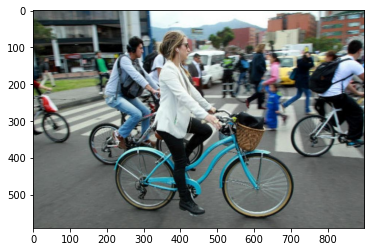

In [0]:
# Leemos la imagen que nos interesa sea procesada por el modelo
imagen = cv2.imread('ciudad.jpg')
# La siguiente línea de código nos sirve para cambiar el formato de imagen
# de RGB a BGR y poder visualizar los colores correctamente al usar la 
# función imshow.
imagen = cv2.cvtColor(imagen, cv2.COLOR_RGB2BGR)
plt.imshow(imagen, cmap='Accent')
plt.show()

In [0]:
# Pre-procesamiento de la imagen.
# Para el modelo Yolo v3 las imágenes de entrada deben ser un tensor de tamaño 1x416x416x3
# Además, deben contar con una normalización para llevar los valores de los pixeles de 0 a 1.
# La siguiente instrucción realiza el escalamiento de la imagen a 416x416, normaliza los
# pixeles y añade la dimensión de 1 al tensor. 
imagenPrep = cv2.dnn.blobFromImage(imagen, 1/255, (416,416))

In [0]:
# Yolo v3 utiliza la convención "channel first" que consiste en tener el numero de canales
# de la imagen que las demensiones de alto y ancho.
imagenPrep.shape

(1, 3, 416, 416)

## Construcción y configuración de Yolo v3

In [0]:
# Construcción del modelo.
# Para esta tarea utilizaremos los archivos de coniguración y pesos que hemos descargado.
modeloYolov3 = cv2.dnn.readNet(yolo_config, yolo_weights)

In [0]:
# Obtención de las capas de salida.
# Recuerda que en Yolo v3 se detectan los objetos desde 3 escalas diferentes de la imagen.
# Las capas que realizan estas detecciones son las que obtendremos.
layersPred = modeloYolov3.getUnconnectedOutLayersNames()
print(layersPred)

['yolo_82', 'yolo_94', 'yolo_106']


In [0]:
# Definición de la imagen de entrada.
# En este paso indicamos al modelo cual es la imagen que debe usar para ejecutar la detección.
modeloYolov3.setInput(imagenPrep)

In [0]:
# Alimentación hacia adelante.
# Recuerda que cuando un modelo ha sido entrenado, la alimentación hacia adelante
# es la tarea que debemos ejecutar para realizar una inferencia.
outputs = modeloYolov3.forward(layersPred)

In [0]:
# La salida del modelo esta embebida en una lista de tamaño 3, que son el numero 
# de capas de las que se obtiene una detección.
len(outputs)

3

In [0]:
# La 1ª etapa de detección se realiza en la capa 82 del modelo.
# Ahí se utilizó una rejilla de 13x13x3, lo que da el tamaño de 507. 
# La 2ª etapa de detección se realiza en la capa 94 del modelo.
# Ahí se utilizó una rejilla de 26x26x3, lo que da el tamaño de 2028.
# La 3ª etapa de detección se realiza en la capa 106 del modelo, que además es la última.
# Ahí se utilizó una rejilla de 52x52x3, lo que da el tamaño de 8112.
# La dimensión de 85 corresponde a la longitud del vector que contiene: 
# Pc, bx, by, bh, bw, c1, c2, ..., c80
outputs[0].shape

(507, 85)

## Reordenamiento de las salidas

In [0]:
# Extraemos la información respecto a los bounding boxes (bboxes)
classesIndexes = [] # Esta lista contendrá, para cada bounding box (bbox), el índice de la clase que obtuvo la más alta probabilidad de pertenecia.
Pcs = []            # Esta lista contendrá, para cada bbox, el score de confianza Pc
bboxes = []         # Esta lista contendrá, para cada bbox, las variables: bx, by, bw, bh.
# Iteramos sobre las predicciones con cada uno de los tres tamaños de imágenes
for out in outputs:
    # Iteramos sobre cada predicción 
    for detection in out:
        # Información sobre el bounding box
        centerX = int(detection[0] * imagen.shape[1])
        centerY = int(detection[1] * imagen.shape[0])
        bw = int(detection[2] * imagen.shape[1])
        bh = int(detection[3] * imagen.shape[0])
        bx = round(centerX - (bw/2))
        by = round(centerY - (bh/2))
        bboxes.append([bx, by, bw, bh])

        # Obtenemos la probabilidad de clase más alta
        # para cada bounding box
        classeId = np.argmax(detection[5:])
        classesIndexes.append(classeId)

        # Obtenemos el score de confinanza para cada 
        # boundingbox
        Pc = detection[4]
        Pcs.append(float(Pc))


## Visualización de los resultados

In [0]:
# non-maximum suppression
# La técnica non-max suppression nos sirve para limpiar los bboxes que no contienen objetos
# o que estan superpuestos a otros. 

# EJERCICIO
# Realiza algunos experimentos cambiando los umbrales score_threshold y nms_threshold y observa
# la diferencia al detectar objetos en la imagen.
# Prueba también diferentes imágenes.
# Recuerda:
# score_threshold controla el rango para descartar bboxes que tienen un Pc bajo, es decir, 
# en los que el modelo no esta seguro de que se trate de un objeto.
# nms_threshold controla el umbral para descartar bboxes que se traslapan con otros a los que
# ya les ha sido asignado un objeto.

indicesFinales = cv2.dnn.NMSBoxes(bboxes, Pcs, score_threshold = 0.6, nms_threshold = 0.5)

In [0]:
# Visualizamos los indices de los bboxes que debemos de tomar en cuenta para 
# dibujarlos en la imagen original
print(indicesFinales)

[[ 253]
 [ 306]
 [1310]
 [ 370]
 [1448]
 [ 282]
 [1358]
 [1119]
 [1193]
 [1184]
 [1098]
 [1265]
 [1092]
 [1101]
 [1068]]


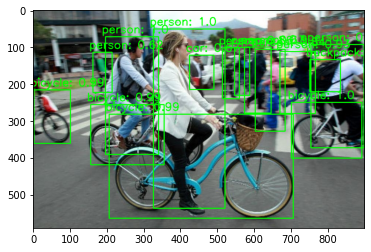

In [0]:
# Iteramos sobre los índices de los bounding boxes finales 
for i in indicesFinales:
    # Obtenemos la información del bounding box i
    i = i[0]    
    x, y, w, h = bboxes[i]          # Medidas para dibujar el bbox
    classeId = classesIndexes[i]    # Indice de la clase a la pertenece el objeto dentro del bbox
    nombreClase = classes[classeId] # Indice de la clase a la pertenece el objeto dentro del bbox
    scoreConfianza = str(round(Pcs[i], 2)) # Score de confianza para el bbox

    # Dibujamos el bounding box en la imagen original
    cv2.rectangle(imagen, (round(x), round(y)), (round(x + w), round(y + h)),
                  (0,255,0), 2)
    # Escribimos un texto con la clase del objeto
    etiqueta = nombreClase + ": " + scoreConfianza
    cv2.putText(imagen, etiqueta, (x - 10, y - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 1,(0,255,0), 2)

plt.imshow(imagen, cmap='Accent')
plt.show()